In [1]:
import numpy as np
#import autograd.numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from numpy.linalg import inv, solve
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)

# The Implementations

In [2]:
def sigma(x):
    return 1 / (1 + np.exp(-x))

def sigma(x): # Numerically more stable version
    return 1 / (1 + np.exp(-np.maximum(x, -20)))

# This version follows the math from the lecture
def irls_step_math(X, y, beta):
    mu = sigma(beta.T.dot(X))
    M = np.diag((mu * (1 - mu))[0]) 
    Minv = np.diag(1/(mu * (1 - mu))[0])
    z = X.T.dot(beta) - Minv.dot((mu - y).T)
    XMXt = X.dot(M).dot(X.T)
    # beta = solve(XMXt, X.dot(M).dot(z))
    beta = inv(XMXt).dot(X).dot(M).dot(z)
    return beta

# This version instead avoids the explicit construction of M and is more numerically stable
def irls_step(X, y, beta):
    mu = sigma(beta.T.dot(X))
    # Have M as a vector. 
    # Then X.dot(M) = X * M, but the latter avoids a (potentially) huge matrix
    M = (mu * (1 - mu))[0] 
    z = X.T.dot(beta) - ((mu - y)/ (M + 1e-8)).T # + 1e-8 to stabilize the numerics
    XMXt = (X * M).dot(X.T) + 1e-8 * np.eye(X.shape[0]) # + 1e-8 to stabilize the numerics
    beta = solve(XMXt, (X*M).dot(z)) # solve instead of inv
    return beta

# This version includes Ridge/L2 regularization
def irls_step_reg(X, y, beta, regularize = 1e-8):
    mu = sigma(beta.T.dot(X))
    M = (mu * (1 - mu))[0] 
    g = X.dot((mu - y).T) + regularize * beta
    H = (X * M).dot(X.T) + regularize * np.eye(X.shape[0])
    beta = beta - inv(H).dot(g)
    # beta = beta - solve(H,g)
    return beta


# Our Negative Log-likelihood loss/ Cross-Entropy
def loss(X, y, beta, regularize=0):
    mu = sigma(beta.T.dot(X))
    reg = regularize * np.sum(beta**2) if regularize > 0 else 0
    return - np.sum(y * np.log(mu + 1e-8) + (1 - y) * np.log(1 - mu + 1e-8)) + reg


def irls(X, y, n_iter=100, regularize=1e-8):
    beta = np.zeros((X.shape[0], 1))
    converged = False
    for i in range(n_iter):
        print(f"Loss({i}/{n_iter}): {loss(X,y,beta, regularize):.2f}")
        beta_old = beta
        if regularize > 0:
            beta = irls_step_reg(X, y, beta, regularize)
        else:
            beta = irls_step(X, y, beta)
        if sum((beta_old - beta)**2) < 1e-5:
            print(f"Converged after {i} iterations")
            converged = True
            break
    if not converged:
        print(f"Stopped after {n_iter} iterations")
    return beta

# 2 Comparison of Logistic to Linear Regression

**Note for the Thursday tutorial participants:** I accidentaly left out the bias term in the implementation which is why I didn't notice that the data of the first part was already linearly separable if we allow for a shifting decision boundary (which the bias allows us to do). Sorry for that. The current version now fixes that and slightly shifts the data so that it is no longer linearly separable. 

In [3]:
def add_bias(X):
    return np.vstack((np.ones((1,X.shape[1])), X))

N = 10
# X = np.hstack([-1.5 + np.random.randn(p, N), 1.5 + np.random.randn(p, N)])
# X = np.hstack([-2 + np.random.randn(p, N), 2 + np.random.randn(p, N)])
# y = np.hstack([np.zeros((1,N)), np.ones((1,N))])
# np.savez("log-reg.npz", X = X, y = y)
tmp = np.load("log-reg.npz")
X = tmp["X"]
X[0,N:] = X[0,N:] - 0.3 # Shift one class so that the data is no longer linearly separable
X = add_bias(X)
y = tmp["y"]
X_test = np.arange(-4,4,0.01)[None]
X_test = add_bias(X_test)

(1, 800)
Stopped after 8 iterations
[[1.96342385]
 [3.69662748]]


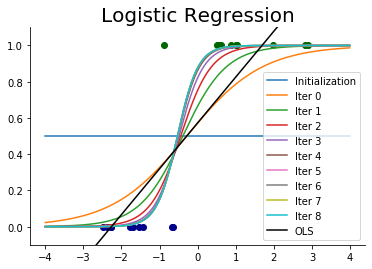

In [4]:
plt.scatter(X[1,:N], y[0,:N], color="darkblue")
plt.scatter(X[1,N:], y[0,N:], color="darkgreen")
beta = np.zeros((X.shape[0], 1))
mu_pred = sigma(beta.T.dot(X_test))
print(mu_pred.shape)
plt.plot(X_test[1,:], mu_pred[0], label="Initialization")
n_iter = 1000
for i in range(n_iter):
    beta_old = 1. * beta
    beta = irls_step(X, y, beta)
    mu_pred = sigma(beta.T.dot(X_test))
    plt.plot(X_test[1], mu_pred[0], label=f"Iter {i}")
    sns.despine()
    if sum((beta_old - beta)**2) < 1e-8:
        print(f"Stopped after {i} iterations")
        break

plt.title("Logistic Regression", fontsize=20)
beta_first = beta
print(beta)
beta_ols = inv(X.dot(X.T)).dot(X).dot(y.T)
plt.plot(X_test[1], beta_ols.T.dot(X_test)[0], color="black", label="OLS")
plt.ylim(-0.1,1.1)
plt.legend()

In [5]:
# Adding the Outlier
X = np.hstack([X, np.array([[1],[10]])])
y = np.hstack([y, np.ones((1,1))])
X_test = np.arange(-4,11,0.01)[None]
X_test = add_bias(X_test)

Stopped after 8 iterations
[[1.96342385]
 [3.69662748]]


(-0.1, 1.1)

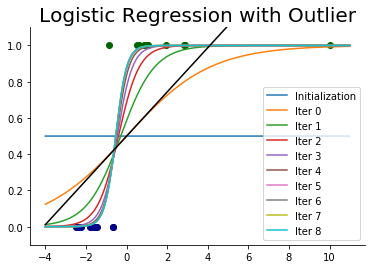

In [6]:
plt.scatter(X[1,:N], y[0,:N], color="darkblue")
plt.scatter(X[1,N:], y[0,N:], color="darkgreen")
beta = np.zeros((2,1))
mu_pred = sigma(beta.T.dot(X_test))
plt.plot(X_test[1], mu_pred[0], label="Initialization")
n_iter = 100
for i in range(n_iter):
    beta_old = 1. * beta
    beta = irls_step(X, y, beta)
    mu_pred = sigma(beta.T.dot(X_test))
    plt.plot(X_test[1], mu_pred[0], label=f"Iter {i}")
    sns.despine()
    if sum((beta_old - beta)**2) < 1e-5:
        print(f"Stopped after {i} iterations")
        break

plt.legend()
plt.title("Logistic Regression with Outlier", fontsize=20)
beta_out = beta
beta
print(beta)
beta_ols2 = inv(X.dot(X.T)).dot(X).dot(y.T)
plt.plot(X_test[1], beta_ols2.T.dot(X_test)[0], color="black", label="OLS")
plt.ylim(-0.1,1.1)

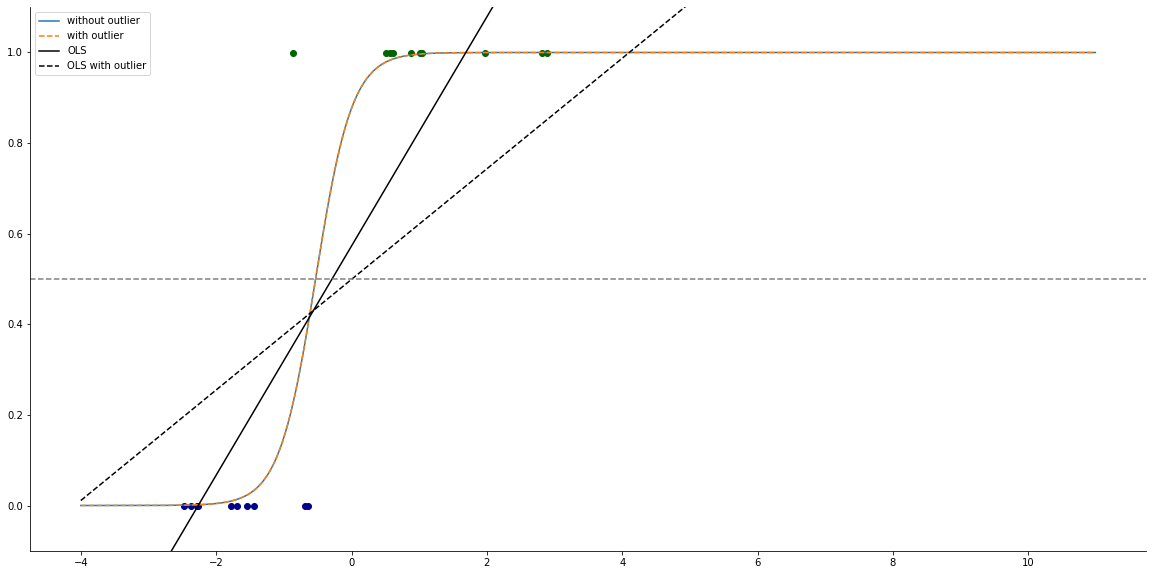

In [17]:
plt.scatter(X[1,:N], y[0,:N], color="darkblue")
plt.scatter(X[1,N:-1], y[0,N:-1], color="darkgreen")
mu_pred = sigma(beta_first.T.dot(X_test))
plt.plot(X_test[1], mu_pred[0], label="without outlier")
mu_pred = sigma(beta_out.T.dot(X_test))
plt.plot(X_test[1], mu_pred[0], label="with outlier", linestyle="dashed")

plt.plot(X_test[1], beta_ols.T.dot(X_test)[0], color="black", label="OLS")
plt.plot(X_test[1], beta_ols2.T.dot(X_test)[0], color="black", linestyle="dashed", label="OLS with outlier")
plt.ylim(-0.1,1.1)
plt.axhline(0.5, color="gray", linestyle="dashed")
plt.legend()
sns.despine()

## iv) Linearly separate data

array([[-502.64364052],
       [ 277.85413495]])

c:\users\1\appdata\local\programs\python\python36\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\users\1\appdata\local\programs\python\python36\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


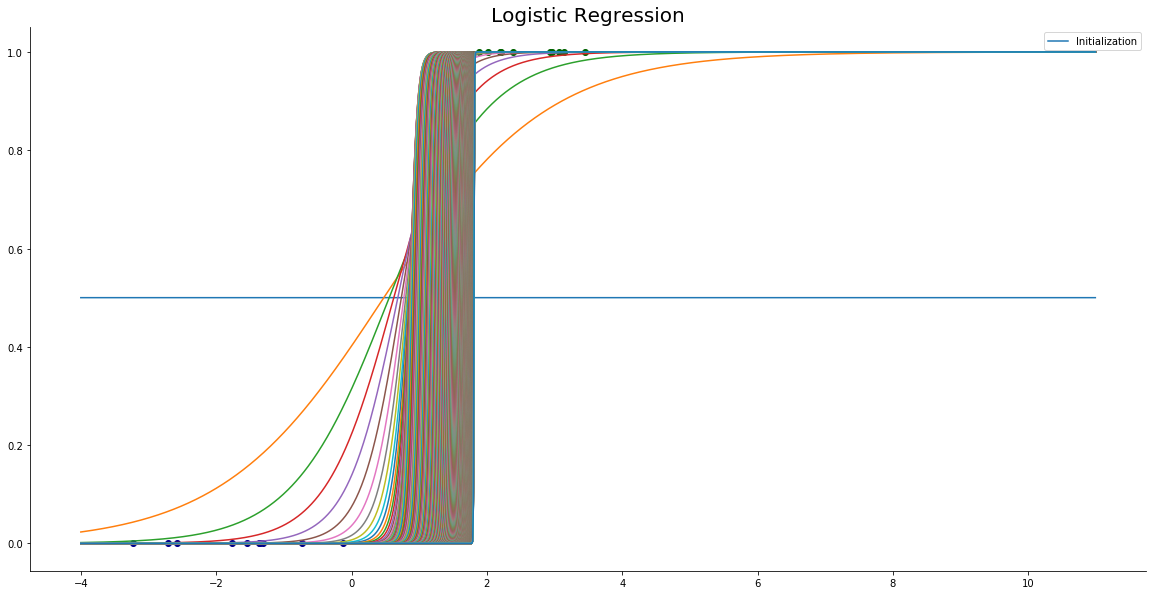

In [18]:
N = 10
X = np.hstack([-2 + np.random.randn(1, N), 2 + np.random.randn(1, N)])
X = add_bias(X)
y = np.hstack([np.zeros((1,N)), np.ones((1,N))])
plt.scatter(X[1,:N], y[0,:N], color="darkblue")
plt.scatter(X[1,N:], y[0,N:], color="darkgreen")
beta = np.zeros((2, 1))
mu_pred = sigma(beta.T.dot(X_test))
plt.plot(X_test[1], mu_pred[0], label="Initialization")
n_iter = 1000
for i in range(n_iter):
    beta_old = 1. * beta
    beta = irls_step_reg(X, y, beta,regularize=0)
    mu_pred = sigma(beta.T.dot(X_test))
    plt.plot(X_test[1], mu_pred[0]) #, label=f"Iter {i}")
    sns.despine()
    if sum((beta_old - beta)**2) < 1e-8:
        print(f"Stopped after {i} iterations")
        break

plt.legend()
plt.title("Logistic Regression", fontsize=20)
beta_first = beta
beta

Stopped after 5 iterations


array([[-0.48027964],
       [ 1.53017145]])

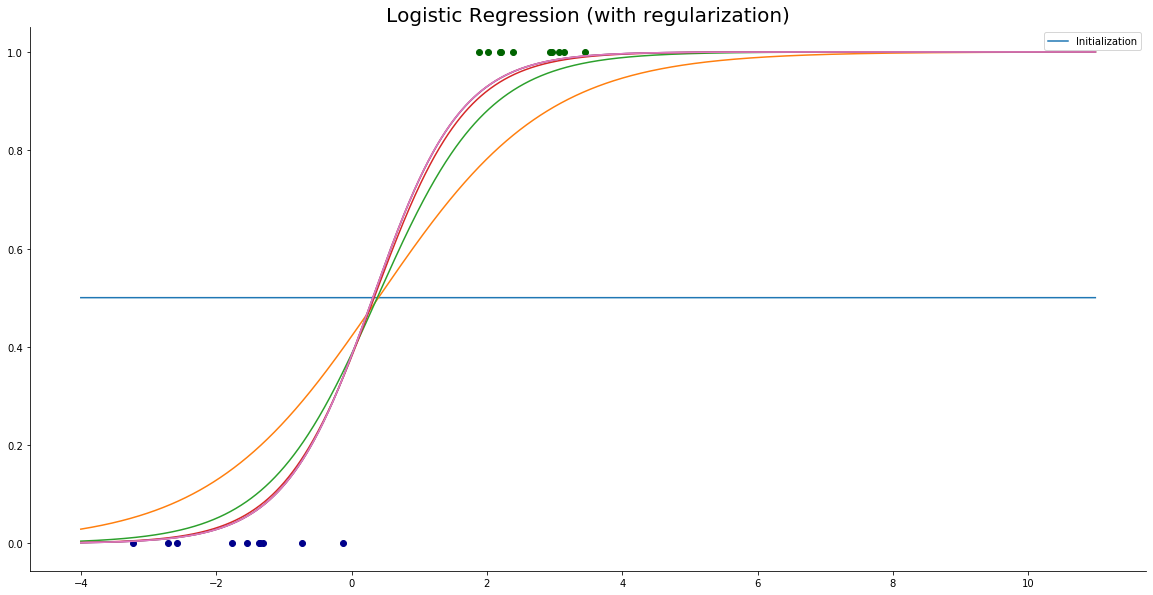

In [19]:
plt.scatter(X[1,:N], y[0,:N], color="darkblue")
plt.scatter(X[1,N:], y[0,N:], color="darkgreen")
beta = np.zeros((2,1))
mu_pred = sigma(beta.T.dot(X_test))
plt.plot(X_test[1], mu_pred[0], label="Initialization")
n_iter = 1000
for i in range(n_iter):
    beta_old = 1. * beta
    beta = irls_step_reg(X, y, beta,regularize=1)
    mu_pred = sigma(beta.T.dot(X_test))
    plt.plot(X_test[1], mu_pred[0]) #, label=f"Iter {i}")
    sns.despine()
    if sum((beta_old - beta)**2) < 1e-8:
        print(f"Stopped after {i} iterations")
        break

plt.legend()
plt.title("Logistic Regression (with regularization)", fontsize=20)
beta_first = beta
beta

# 3 Fitting Logistic Regression to Multidimensional Data

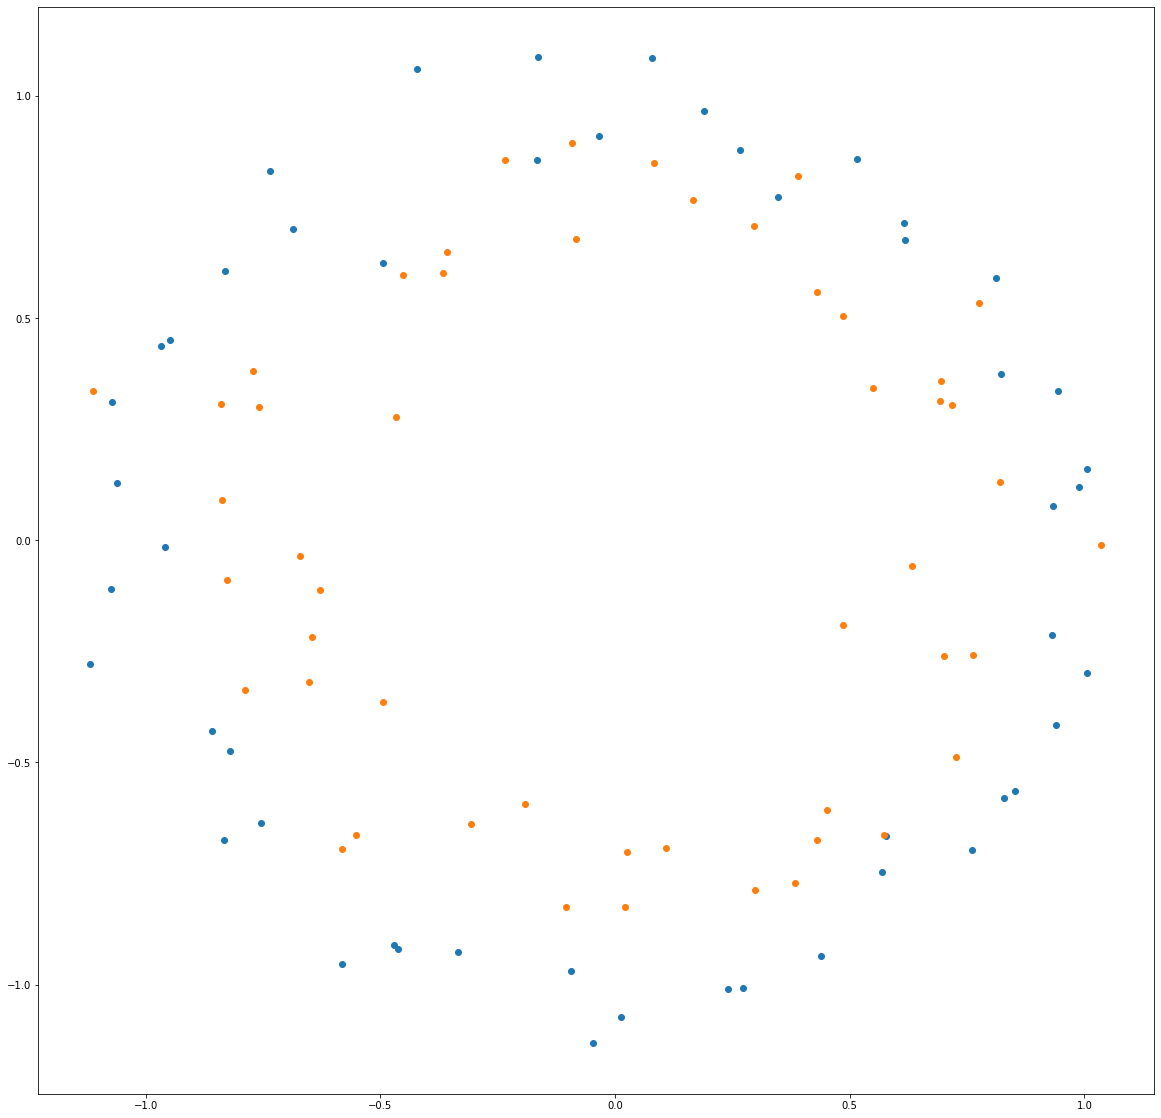

In [7]:
plt.rcParams["figure.figsize"] = (20,20)
from sklearn.datasets import make_circles
N = 100
# X_orig, y_orig = make_circles(N, noise=0.1)
# np.savez("log-reg2", X=X, y=y)
tmp = np.load("log-reg2.npz")
X_orig = tmp["X"].T
y_orig = tmp["y"][0]

plt.scatter(X_orig[y_orig==0,0], X_orig[y_orig==0,1])
plt.scatter(X_orig[y_orig==1,0], X_orig[y_orig==1,1])
X = X_orig.T

y = y_orig[None]


In [8]:
def create_features(X, degree=7):
    data = np.stack([X[0]**i * X[1]**(d-i) for d in range(0,degree) for i in range(d+1)])
    return data

In [9]:
beta = irls(create_features(X, 2), y, n_iter=100, regularize=0.0001)
print(beta.min(), beta.max())

Loss(0/100): 69.31
Loss(1/100): 69.29
Converged after 1 iterations
0.0005710238016002332 0.06523928515097903


In [25]:
xseq = np.arange(-1.5, 1.5, 0.01)
yseq = np.arange(-1.5, 1.5, 0.01)
xgrid, ygrid = np.meshgrid(xseq, yseq)
test_points = np.vstack([xgrid.reshape(1,-1), ygrid.reshape(1,-1)])
ypred = sigma(beta.T.dot(create_features(test_points)))[0]
plt.scatter(test_points[0, ypred < 0.5], test_points[1, ypred < 0.5], alpha=0.1)
plt.scatter(test_points[0, ypred > 0.5], test_points[1, ypred > 0.5], alpha=0.1)

plt.scatter(X_orig[y_orig==0,0], X_orig[y_orig==0,1], color="darkblue")
plt.scatter(X_orig[y_orig==1,0], X_orig[y_orig==1,1], color="orange")
plt.ylim(-1.5,1.5)
plt.xlim(-1.5,1.5)

ValueError: shapes (1,3) and (28,90000) not aligned: 3 (dim 1) != 28 (dim 0)

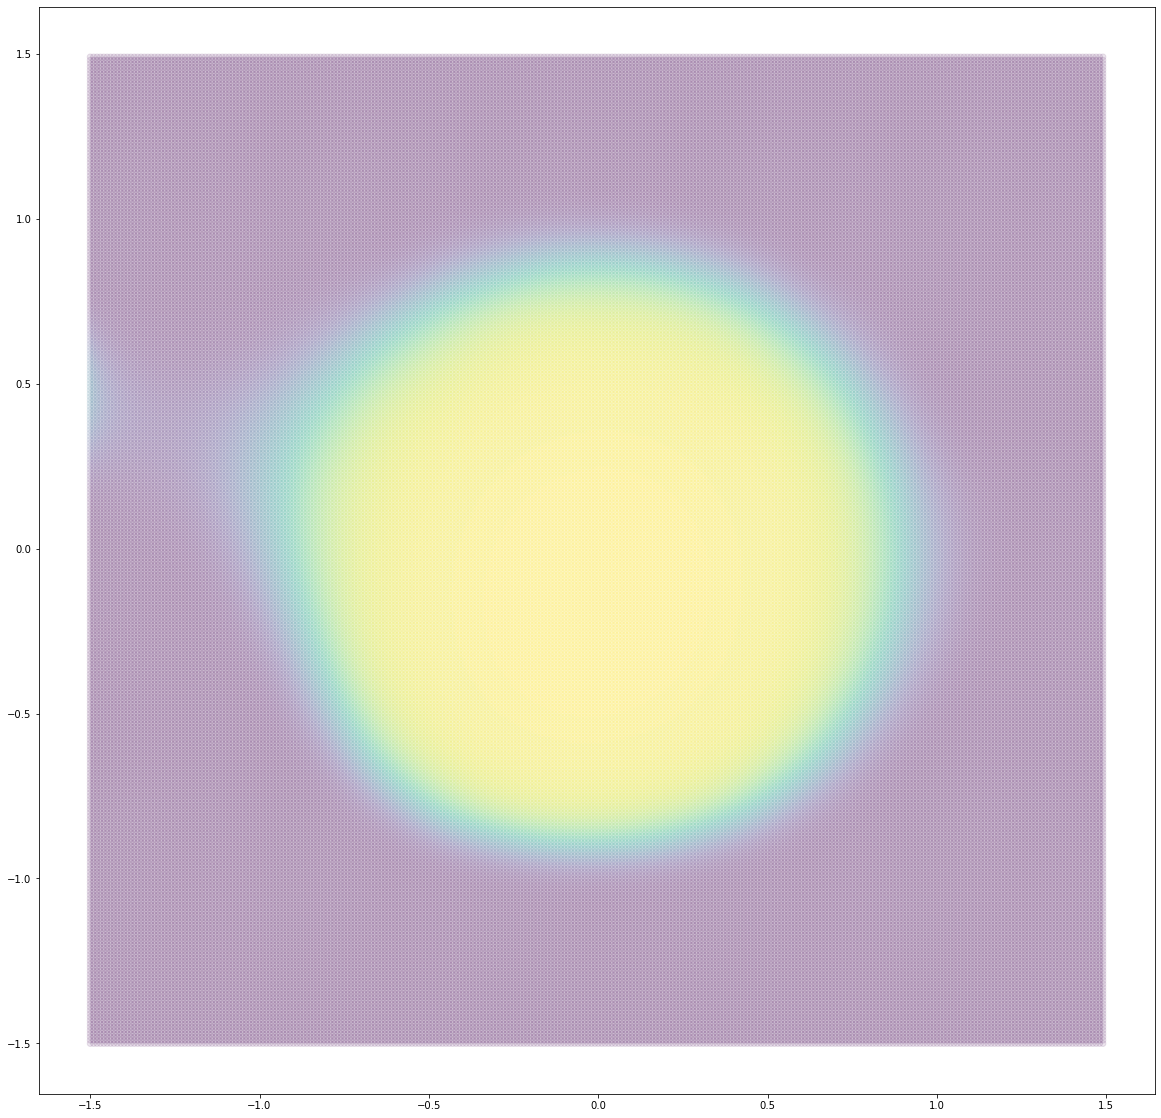

In [22]:
plt.scatter(test_points[0], test_points[1], c=ypred, alpha=0.1)